# Приложение для знакомств

Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

##### Задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

#### Результат работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим метрики
    - Построим графики
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше?



In [5]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

# 1: загружаем

In [6]:
matches = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/txn7q-CE2zSaPg')
matches

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [7]:
matches.shape

(14514, 4)

In [8]:
matches.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [9]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [10]:
matches.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [11]:
matches.user_id_1.value_counts()

170    29
38     28
827    28
198    27
819    26
       ..
661     3
943     3
30      2
904     2
436     1
Name: user_id_1, Length: 1000, dtype: int64

Видим, что существует градация пользователей по активности использщования приложения. Попробуем посмотреть, к какой группе они относятся

In [12]:
matches[matches.user_id_1 == 170]

,user_id_1,user_id_2,group,is_match
29,170,67,1,1
316,170,142,1,1
1733,170,238,1,0
1851,170,885,1,0
1937,170,598,1,1
2020,170,548,1,0
2210,170,809,1,1
2959,170,333,1,1
3744,170,699,1,1
3979,170,265,1,1


In [13]:
matches[matches.user_id_1 == 129]

,user_id_1,user_id_2,group,is_match
767,129,21,0,0
11970,129,766,0,0
13210,129,870,0,0


In [14]:
matches.user_id_2.value_counts()

238    34
716    34
787    33
981    32
314    31
       ..
104     4
650     4
46      4
27      3
883     3
Name: user_id_2, Length: 1000, dtype: int64

In [15]:
matches[matches.user_id_2 == 716]

,user_id_1,user_id_2,group,is_match
320,724,716,1,0
682,617,716,1,1
1021,289,716,1,0
2091,804,716,1,0
2402,512,716,1,0
3158,272,716,1,0
3673,514,716,1,0
3843,404,716,1,0
4169,310,716,1,1
4348,139,716,1,0


In [16]:
matches[matches.user_id_2 == 650]

,user_id_1,user_id_2,group,is_match
2268,45,650,0,0
9331,995,650,0,0
12634,822,650,0,0
12653,926,650,0,0


# 2: графики, гипотезы и тесты

Судя по данным, мы можем предположить, что у пользоваталей в тестовой группе по сравнению с пользователями старой версии приложения может быть выше:
- процент мэтчей среди всех пар пользователей (назовем эту метрику General Match Rate - **GMR**);
- среднее количество мэтчей на одного пользователя (назовем эту метрику Average Matches Per User - **AMPU**).

## 2.1. Процент мэтчей среди всех пар пользователей - GMR 

Посчитаем GMR по формуле: общее количество мэтчей в группе / общее количество пар пользователей в группе.

Если GMR  увеличился, то новый алгоритм работает лучше.

Сформируем датафрейм с данными о:
- общем количестве всех пар пользователей в каждой группе - "all_couples"
- общем количестве мэтчей в каждой группе - "is_match"
- доле мэтчей среди всех пар пользователей - "GMR"

In [17]:
GMR = matches.groupby("group", as_index=False).user_id_1.count() \
    .rename(columns={"user_id_1" : "all_couples"})

GMR_ = matches.query("is_match == 1").groupby("group", as_index=False).is_match.count()

GMR = GMR.merge(GMR_, on="group")

GMR['GMR'] = (GMR.is_match / GMR.all_couples).mul(100).round(1)

GMR

,group,all_couples,is_match,GMR
0,0,4792,934,19.5
1,1,9722,3909,40.2


Теперь визуализируем данные по GMR для большей наглядности

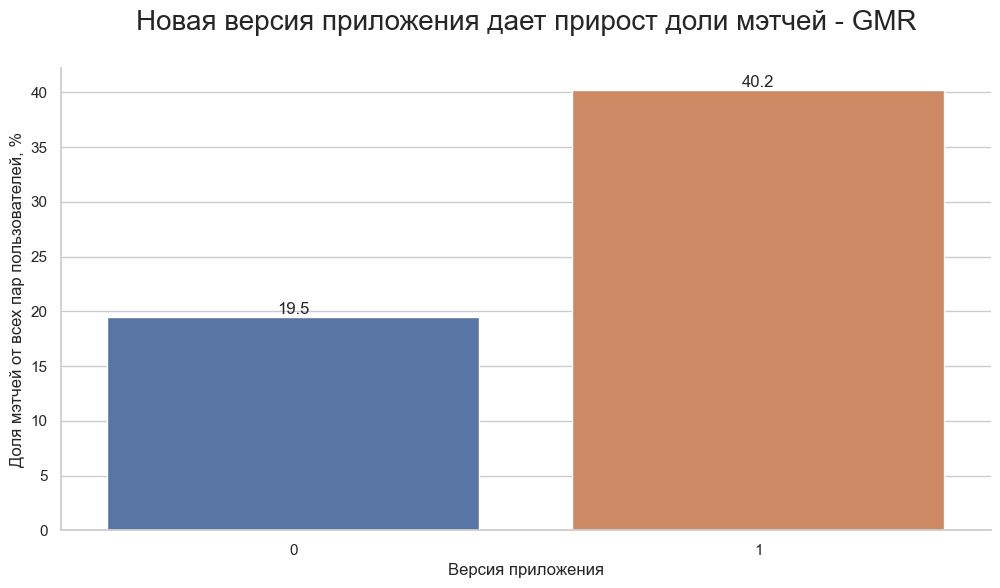

In [18]:
ax = sns.barplot(data=GMR, y="GMR", x="group")

ax.bar_label(ax.containers[0])

ax.set_ylabel('Доля мэтчей от всех пар пользователей, %')
ax.set_xlabel('Версия приложения')
ax.set_title('Новая версия приложения дает прирост доли мэтчей - GMR\n', fontsize=20)
sns.despine()  # убрать часть рамки графика
sns.set_style("white")
plt.show()

### Видно, что GMR сильно изменился в новой версии приложения

## 2.2. Среднее количество мэтчей на одного пользователя - AMPU

Собираем датафрейм с данными о количестве мэтчей на каждого пользователя в каждой группе

In [19]:
AMPU = matches.groupby(["user_id_1", "group"], as_index=False).is_match.count()

AMPU

,user_id_1,group,is_match
0,1,1,24
1,2,1,16
2,3,1,16
3,4,0,9
4,5,1,22
...,...,...,...
995,996,0,8
996,997,0,12
997,998,1,18
998,999,0,7


Теперь считаем среднее значение мэтчей на одного пользователя - AMPU - для каждой группе

In [20]:
AMPU.groupby(["group"], as_index=False).is_match.mean().round(1).rename(columns={"is_match" : "AMPU"})

,group,AMPU
0,0,9.6
1,1,19.5


Сделаем визуализацию результатов

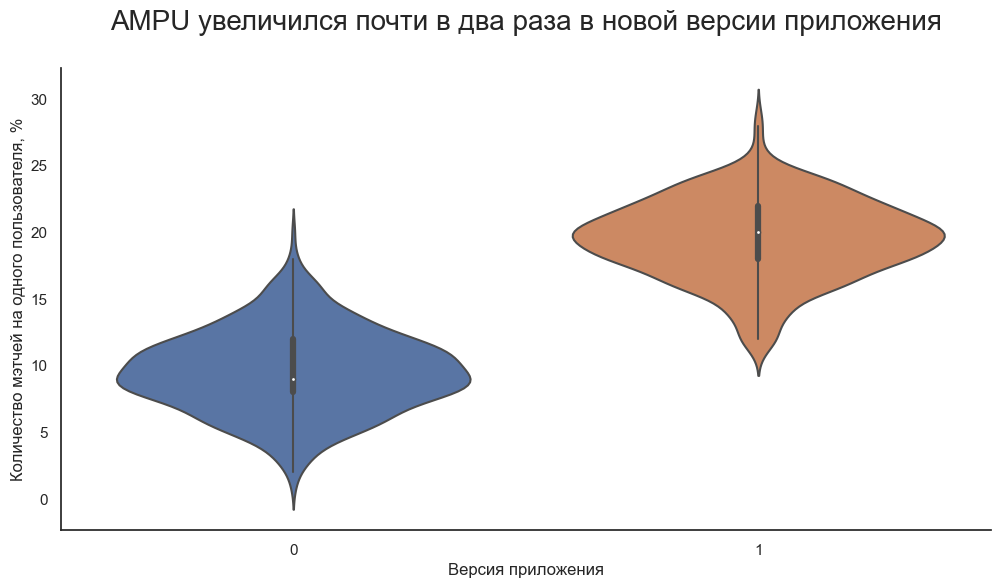

In [21]:
ax = sns.violinplot(data=AMPU, x="group", y="is_match")

ax.set_ylabel('Количество мэтчей на одного пользователя, %')
ax.set_xlabel('Версия приложения')
ax.set_title('AMPU увеличился почти в два раза в новой версии приложения\n', fontsize=20)
sns.despine()  # убрать часть рамки графика

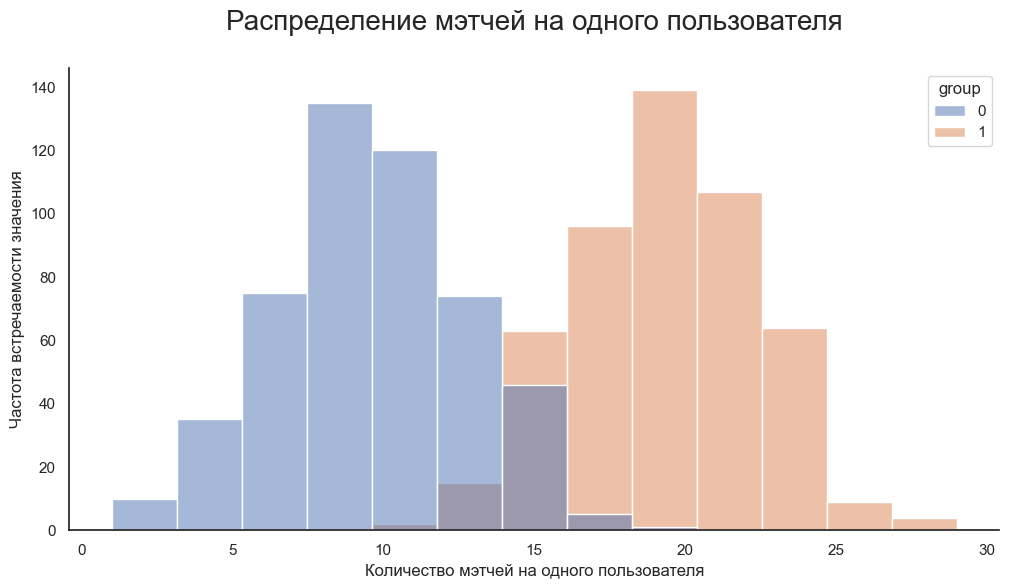

In [22]:
ax = sns.histplot(AMPU, x="is_match", hue="group")

ax.set_ylabel('Частота встречаемости значения')
ax.set_xlabel('Количество мэтчей на одного пользователя')
ax.set_title('Распределение мэтчей на одного пользователя\n', fontsize=20)
sns.despine()  # убрать часть рамки графика

### Видим по графикам, что AMPU увеличился в почти двое и средние значения в группах значимо различаются.

### Теперь необходимо проверить статистическую значимость выявленных различий по обозначенным нами метрикам

# 3: Тестируем гипотезы

## 3.1. Проверяем результаты по GMR

Поскольку мы проверяем взаимосвязь между двумя категориальными переменными, то воспользуемся хи-квадратом

In [23]:
expected, observed, stats = pg.chi2_independence(matches, x='group', y='is_match')

In [24]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


### Результаты теста показали, что p-value меньше 0.05, а значит мы можем отклонить нулевую гипотезу об отсуствии статистически значимой разницы между ожидаемыми и наблюдаемыми частотами переменной "is_match"

## 3.2. Проверяем результаты по AMPU

Проверяем данные на гомоскедастичность

In [25]:
pg.homoscedasticity(data=AMPU, dv="is_match", group="group")

,W,pval,equal_var
levene,0.480454,0.488378,True


Тест показал, что нулевая гипотеза о гомоскедастичности данных не опровегнута. Значит считаем что данные в обеих группах обладают гомоскедастичностью

Проверяем данные на нормальность распределения

In [26]:
pg.normality(data=AMPU, dv="is_match", group="group", method = "normaltest")

,W,pval,normal
group,,,
1,4.262189,0.118707,True
0,2.406168,0.300267,True


Тест показал, что нулевая гипотеза о нормальности распределения данных в обеих группах не опровергнута. Значит считаем данные нормально распределенными.

Поскольку данные обладают нормальным распределением и гомоскедастичностью, то мы можем воспользоваться дисперсионным анализом (ANOVA)

In [27]:
AMPU.anova(dv="is_match", between=["group"]).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,1,998,2688.82,0.0,0.729


### Результаты теста показали, что p-value меньше 0.05, а значит, что мы можем отклонить нулевую гипотезу о том, что средние значения в двух группах статистически не различаются. 

## 4: Подводим итоги

Новая версия приложения увиличила GMR и AMPU практически два раза.

Между метриками новой и старой версии приложения есть статистически значимые различия, а величина разницы между метриками имеет существенное значение для бизнеса.

### Предлагаемое решение - Запускаем новую версию приложения в прод